## Passo 0 - Importando bibliotecas

In [2]:
# Pacotes padrao
import os
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from datetime import datetime
import seaborn as sns


#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Modelos
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score, mean_squared_error

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

# copiando sidmodel porque ele não estava escrevendo a ordem correta dos modelos
from copy import copy, deepcopy

#statsmodels for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# import scienceplots
# plt.style.use(['science', 'ieee', 'notebook'])
plt.style.use(['seaborn-v0_8-whitegrid'])
# plt.style.use(['seaborn-whitegrid'])


## Passo 0 - Importando os dados

recovering from picke, comment if not necessary

In [2]:
# prefix = 'ENSV5B.MISO.W1'
# binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
# print(binary)

# with open(binary, 'rb') as bin_file:
#     X1_tr, y_tr, X1_te, y_te, order_progression2, df = pickle.load(bin_file)


### 0.1 - Lendo dados

In [3]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)


c:\Users\bewm\Documents\Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\data\volve_compiled.pkl


In [4]:
for wellp in data['OP'].keys():
    print(wellp)


15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Selecionando dados

In [5]:
# case = "15/9-F-14"
case = "15/9-F-1 C"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


Plotando dados

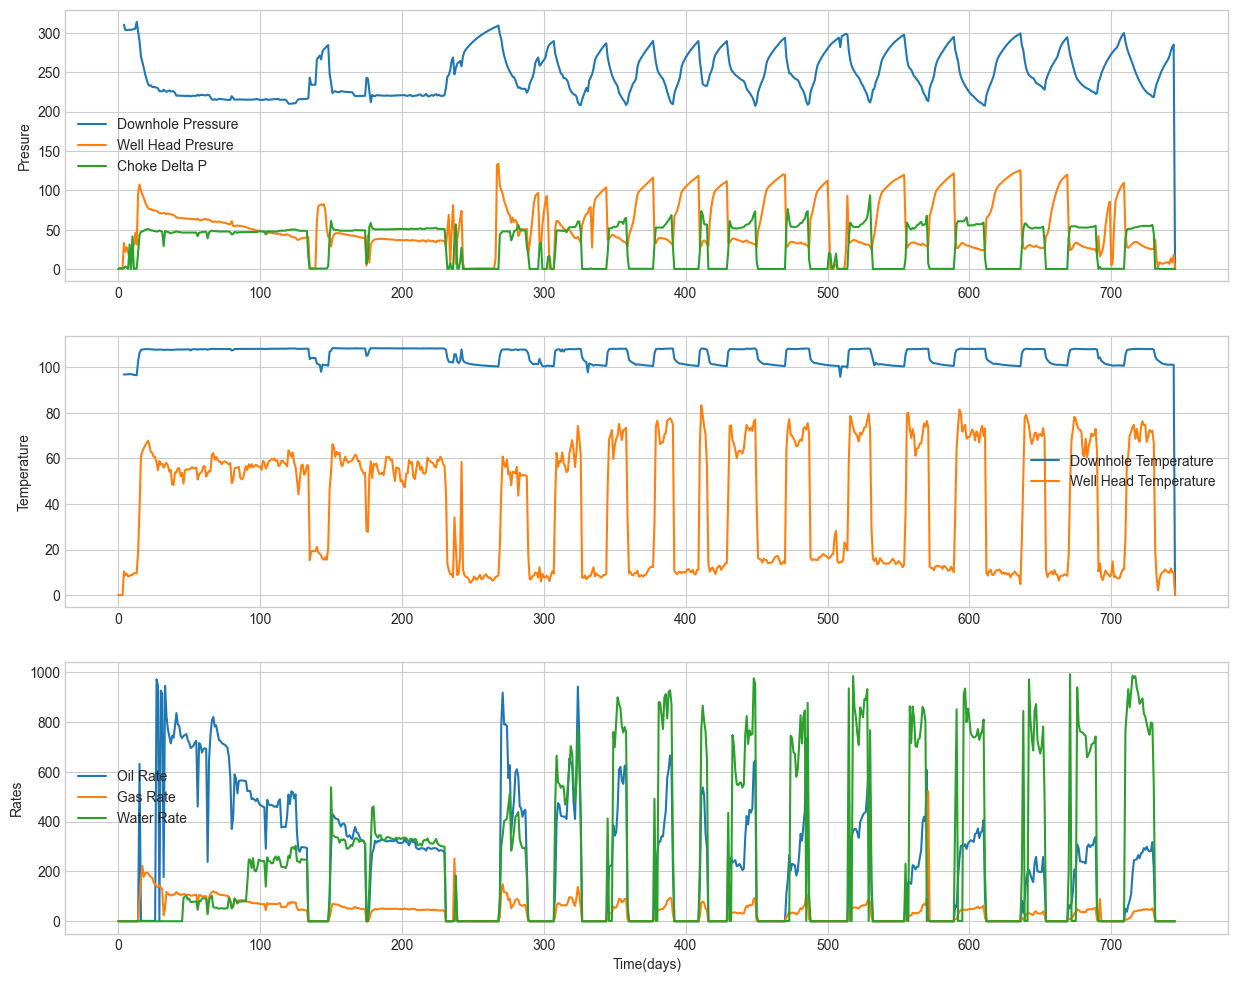

In [6]:
time = data_case['N']

plot_dict_P = {
'AVG_DOWNHOLE_PRESSURE':'Downhole Pressure',
'AVG_WHP_P':'Well Head Presure',
# 'AVG_DP_TUBING':'Tubing Delta P',
# 'AVG_ANNULUS_PRESS':'Annulus Pressure',
'AVG_CHOKE_SIZE_P':'Choke Delta P',
# 'DP_CHOKE_SIZE':'DP_CHOKE_SIZE_P',
}
plot_dict_T = {
'AVG_DOWNHOLE_TEMPERATURE':'Downhole Temperature',
'AVG_WHT_P':'Well Head Temperature',
}
plot_dict_Q = {
'BORE_OIL_VOL':'Oil Rate',
'BORE_GAS_VOL':'Gas Rate',
'BORE_WAT_VOL':'Water Rate',
}

fig, ax = plt.subplots(3,1, figsize=(15,12))

for k,v in plot_dict_P.items():
    ax[0].plot(time, data_case[k], label=v)

for k,v in plot_dict_T.items():
    ax[1].plot(time, data_case[k], label=v)

for k,v in plot_dict_Q.items():
    ax[2].plot(time, data_case[k], label=v)

ax[0].legend(fontsize='10')
ax[0].set_ylabel('Presure')

ax[1].legend(fontsize='10')
ax[1].set_ylabel('Temperature')

ax[2].legend(fontsize='10')
ax[2].set_xlabel('Time(days)')
ax[2].set_ylabel('Rates')


# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '0_well_data.eps')
# fig.savefig(p, format='eps')
pass;


In [7]:
data_case = data_case.iloc[28:,:]
data_case = data_case[filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values


## Seasonal decompose

Sem decompor as entradas por enquanto


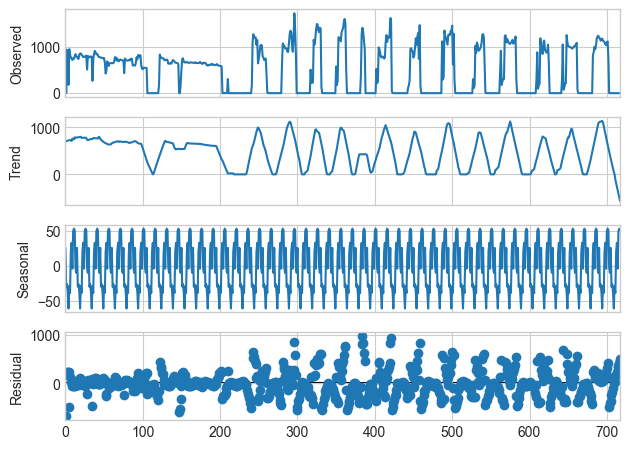

In [8]:
result = seasonal_decompose(y, model='additive', period=15, extrapolate_trend='freq')
fig = result.plot()
yt=result.trend.reshape(-1,1)
ys=result.seasonal.reshape(-1,1)
yr=result.resid.reshape(-1,1)

fig.axes[0].set_ylabel('Observed')
fig.axes[0].set_title('')

pass;


In [1]:
plt.plot(y, label='original', 'o')
plt.plot(yt+ys, label='trend+seasonal')
plt.legend()


SyntaxError: positional argument follows keyword argument (3244345037.py, line 1)

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [9]:
p_train = 0.7 #70% treino


### 1.2 - Separando os conjuntos

In [10]:
n_train = int(X1.shape[0]*p_train)

X1_tr = X1[:n_train,:]
X1_te = X1[:,:]

y_tr = y[:n_train,:]
yt_tr = yt[:n_train,:]
ys_tr = ys[:n_train,:]
yr_tr = yr[:n_train,:]

y_te = y[:,:]
yt_te = yt[:,:]
ys_te = ys[:,:]
yr_te = yr[:,:]


In [11]:
print(
    X1.shape,
    X1_tr.shape,
    X1_te.shape
)
print(
    y.shape,
    y_tr.shape,
    y_te.shape,
)
print(
    yt.shape,
    yt_tr.shape,
)


(718, 5) (502, 5) (718, 5)
(718, 1) (502, 1) (718, 1)
(718, 1) (502, 1)


### 1.3 - Removendo a escala 

In [12]:

X_tr = MinMaxScaler().fit_transform(X1_tr)
X_te = MinMaxScaler().fit_transform(X1_te)

y_tr = MinMaxScaler().fit_transform(y_tr)
yt_tr = MinMaxScaler().fit_transform(yt_tr)
yr_tr = MinMaxScaler().fit_transform(yr_tr)
ys_tr = MinMaxScaler().fit_transform(ys_tr)

y_te = MinMaxScaler().fit_transform(y_te)
yt_te = MinMaxScaler().fit_transform(yt_te)
ys_te = MinMaxScaler().fit_transform(ys_te)
yr_te = MinMaxScaler().fit_transform(yr_te)


## Passo 2 - Declarando os modelos 

In [13]:
models = []


### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [14]:
models_ml = [
    ('LinReg'             ,      LinearRegression(copy_X=True)), #ARX Equivalet
    ('RidgeReg'           ,      Ridge()),
    ('PolyReg'            ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivale)t
    ('SVM'                ,      SVR(max_iter=-1)),
    ('KNN'                ,      KNeighborsRegressor()),
    ('MLP'                ,      MLPRegressor(random_state=rs)),
    ('DecisionTree'       ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'       ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting'   ,      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'         ,      ExtraTreesRegressor(random_state=rs)),
    ('AdaBoostRegressor'  ,      AdaBoostRegressor(random_state=rs)),
    ('BaggingRegressor'   ,      BaggingRegressor(random_state=rs)),
    ('LightGBM'           ,      lgb.LGBMRegressor()),
    ('XGBoost'            ,      xgb.XGBRegressor()),
]

for i, m in enumerate(models_ml):
    # print (m[0])
    print (i, m[0])


0 LinReg
1 RidgeReg
2 PolyReg
3 SVM
4 KNN
5 MLP
6 DecisionTree
7 RandomForest
8 GradientBoosting
9 ExtraTrees
10 AdaBoostRegressor
11 BaggingRegressor
12 LightGBM
13 XGBoost


#### 2.3.2 - Parâmetros (RandomSearchCV)

In [17]:

parameters = [
    { # LinReg 0
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RidgeReg 1
        'positive'                     : [True, False],
    },
    { # PolyReg NARX 3
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # SVM 4
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # KNN 5
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # MLP 6
        'activation'            : ['relu', 'tanh'],
        'early_stopping'        : [True],
        'learning_rate_init'    : stats.loguniform(1e-4, 0.01),
        # 'learning_rate'         : ['adaptive', 'constant'],
        'alpha'                 : stats.loguniform(1e-5, 1e-3),
        'hidden_layer_sizes'    : []
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=3)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=4)],
        # 'max_iter'              : [10000],#stats.randint(200,10000),
        # 'batch_size'            : [32],
        # 'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),
    },
    { # DecisionTree 7
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RandomForest 8
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # GradientBoosting 9
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(),
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # ExtraTrees 10
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # AdaBoostRegressor 11
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 10),
        'loss'                      : ['linear', 'square', 'exponential'],
    },
    { # BaggingRegressor 12
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'max_samples'               : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_features'              : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'bootstrap'                 : [True, False],      #maxima quantidade de features para embasar a decisao de divisao
    },
    { # LightGBM 13
        'num_leaves'                : stats.randint(5,100), # max num folhas dos base learners
        'n_estimators'              : stats.randint(10,200), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 1),
        # 'max_depth'                 : stats.randint(1,20), #maxima profundidade da arvore
    },
    { # XGBoost 14
        'n_estimators'           : stats.randint(2,100), #Numero de arvores
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'learning_rate'          : stats.loguniform(1e-3, 1),
    },
]


In [18]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)


In [19]:
n_iter = 40 #Numero de iterações do rdmsearch
models = []
for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', param_distributions=params, n_iter=n_iter, n_jobs=6, cv=rkf, random_state=rs)

    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch,
        )

    models.append(
        (model[0], sidmodel)
    )


In [20]:
# 0 LinReg
# 1 RidgeReg
# 2 PolyReg
# 3 SVM
# 4 KNN
# 5 MLP
# 6 DecisionTree
# 7 RandomForest
# 8 GradientBoosting
# 9 ExtraTrees
# 10 AdaBoostRegressor
# 11 BaggingRegressor
# 12 LightGBM
# 13 XGBoost
models_choice = [0,1,2,4,5,7,8,11,12,13]
# models_choice = [0,1]
for model in np.array(models)[models_choice]:
    print (model[0])


LinReg
RidgeReg
PolyReg
KNN
MLP
RandomForest
GradientBoosting
BaggingRegressor
LightGBM
XGBoost


In [21]:
# orders = [2, 4, 6, 10, 12, 15, 20]
orders = [2, 4, 6 ]


In [29]:
order_progression2 = {
    'MODEL':[],
    'ORDER':[],
    'R2_TRAIN_OSA':[],
    'R2_TEST_OSA':[],
    'R2_TRAIN_FS':[],
    'R2_TEST_FS':[],
    'RMSE_TRAIN_OSA':[],
    'RMSE_TEST_OSA':[],
    'RMSE_TRAIN_FS':[],
    'RMSE_TEST_FS':[],
    'MODEL_OBJ':[],
}

t00 = datetime.now()

#Loop principal, iterando sobre as listas
for order in orders:
    print(f'Order {order}')

    t0 = datetime.now()

    for model in np.array(models)[models_choice]:
        model_name, sidmodel = model

        print(f'\t{model_name}',end='...')

        sidmodel.nX = order
        sidmodel.ny = order

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)

        # predictions
        y_hat = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
        y_hat_tr = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)

        # residuals
        yr_tr = y_tr - y_hat_tr

        # training again in residuals
        model_name, sidmodel_r  = model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel_r.fit(X=X1_tr, y=yr_tr)

        yr_hat = sidmodel_r.predict(X1_te, y=y_te ,steps_ahead=1)
        yf_hat = y_hat+yr_hat

        r2_te_osa       = r2_score(y_te,  y_hat)
        f_r2_te_osa     = r2_score(y_te,  yf_hat)

        # rmse_tr_osa = mean_squared_error(y_tr, sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1))**0.5
        # rmse_te_osa = mean_squared_error(y_te, sidmodel.predict(X1_te, y=y_te, steps_ahead=1))**0.5
        # try:
            # r2_tr_fs = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
            # r2_te_fs = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
            # rmse_tr_fs = mean_squared_error(y_tr, sidmodel.predict(X1_tr, y=y_tr))**0.5
            # rmse_te_fs = mean_squared_error(y_te, sidmodel.predict(X1_te, y=y_te))**0.5
        # except ValueError:
            # r2_tr_fs = 1e290
            # r2_te_fs = 1e290
            # rmse_tr_fs = 1e290
            # rmse_te_fs = 1e290

        # order_progression2['MODEL'].append(model_name)
        # order_progression2['ORDER'].append(order)
        # order_progression2['R2_TRAIN_OSA'].append(r2_tr_osa)
        # order_progression2['R2_TEST_OSA'].append(r2_te_osa)
        # order_progression2['R2_TRAIN_FS'].append(r2_tr_fs)
        # order_progression2['R2_TEST_FS'].append(r2_te_fs)
        # order_progression2['RMSE_TRAIN_OSA'].append(rmse_tr_osa)
        # order_progression2['RMSE_TEST_OSA'].append(rmse_te_osa)
        # order_progression2['RMSE_TRAIN_FS'].append(rmse_tr_fs)
        # order_progression2['RMSE_TEST_FS'].append(rmse_te_fs)
        # order_progression2['MODEL_OBJ'].append(deepcopy(sidmodel))
        # print(f'\tFS(Test): R2={r2_te_fs:.3f}, RMSE={rmse_te_fs:.3f}')
        # print(f'\t\tOSA(Test): N={r2_te_osa:.3f},T={t_r2_te_osa:.3f},S={s_r2_te_osa:.3f},TS={ts_r2_te_osa:.3f},R={r_r2_te_osa:.3f},F={f_r2_te_osa:.3f},F2={f2_r2_te_osa:.3f}')
        print(f'\t\tOSA(Test): N={r2_te_osa:.3f},F={f_r2_te_osa:.3f}')

    print(f'Tempo (ordem): {datetime.now()-t0}\nTempo (acum): {datetime.now()-t00}\n')


Order 2
	LinReg...		OSA(Test): N=0.787,F=0.772
	RidgeReg...		OSA(Test): N=0.788,F=0.775
	PolyReg...		OSA(Test): N=0.799,F=0.238
	KNN...		OSA(Test): N=0.883,F=0.878
	MLP...		OSA(Test): N=0.767,F=0.782
	RandomForest...		OSA(Test): N=0.852,F=0.847
	GradientBoosting...		OSA(Test): N=0.848,F=0.847
	BaggingRegressor...		OSA(Test): N=0.906,F=0.903
	LightGBM...		OSA(Test): N=0.891,F=0.885
	XGBoost...		OSA(Test): N=0.868,F=0.863
Tempo (ordem): 0:13:18.580198
Tempo (acum): 0:13:18.581199

Order 4
	LinReg...		OSA(Test): N=0.795,F=0.758
	RidgeReg...		OSA(Test): N=0.797,F=0.777
	PolyReg...		OSA(Test): N=0.803,F=0.311
	KNN...		OSA(Test): N=0.879,F=0.862
	MLP...		OSA(Test): N=0.651,F=0.716
	RandomForest...

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(order_progression2)
df[df['MODEL']=='LinReg']
# df


In [ ]:
df_r2 = df.pivot("MODEL", "ORDER", "R2_TEST_FS")
df_r2['mean'] = df_r2.mean(axis=1)
df_r2['max'] = df_r2.max(axis=1)

df_rmse = df.pivot("MODEL", "ORDER", "RMSE_TEST_FS")
df_rmse['mean'] = df_rmse.mean(axis=1)
df_rmse['min'] = df_rmse.min(axis=1)


In [ ]:
fsize=(4,3)
sns.set(font_scale=0.4)
cmap = matplotlib.cm.RdYlGn

fig = plt.figure(figsize=fsize)
ax = sns.heatmap(data=df_r2.sort_values('max', ascending=False).iloc[:,:-2], annot=True, vmin=.5, vmax=.75, fmt='.3f',cmap=cmap, linewidths=.1, annot_kws={'size': 4})
ax.set(xlabel='Lag', ylabel="")
ax.tick_params(left=True, bottom=True, length=2, width=.5)
plt.title('Total Data Free Simulation $R^2$ score for all regressors and all lags')
fig = plt.figure(figsize=(9,7))
sns.heatmap(data=df_r2.sort_values('max', ascending=False).iloc[:,:-2], annot=True, vmin=.5, vmax=.75, fmt='.3f')
plt.xlabel('Lag')
plt.title('R2 score for all regressors and all lags')

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '1_r2_order.eps',)
fig.savefig(p, format='eps')

fig = plt.figure(figsize=fsize)
ax = sns.heatmap(data=df_rmse.sort_values('min', ascending=True).iloc[:,:-2], annot=True, vmin=0.14, vmax=.20, fmt='.3f',cmap=cmap.reversed(), linewidths=.1, annot_kws={'size': 4})
ax.set(xlabel='Lag', ylabel="")
ax.tick_params(left=True, bottom=True, length=2, width=.5)
plt.title('Total Data Free Simulation $RMSE$ score for all regressors and all lags')
fig = plt.figure(figsize=(9,7))
sns.heatmap(data=df_rmse.sort_values('min').iloc[:,:-2], vmin=0.14, vmax=.20, annot=True, fmt='.3f')
plt.xlabel('Lag')
plt.title('RMSE score for all regressors and all lags')

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '2_rmse_order.eps')
fig.savefig(p, format='eps')

pass;


In [ ]:
df_rank = df.sort_values(by='R2_TEST_FS', ascending=False).drop_duplicates(subset=['MODEL']).reset_index()
df_rank.to_clipboard()
df_rank


In [ ]:
df_rank.groupby(by=['MODEL'])['R2_TEST_FS'].max().sort_values(ascending=False)


In [ ]:

sns.set(font_scale=.6, style='ticks')

catplot = sns.catplot(data=df, y='CLASS', x='R2_TEST_FS', hue='MODEL', kind='swarm', height=3.6, aspect=1.2, s=30, palette='tab20')
plt.xlim((.5,.75))
plt.xlabel('$R^2$')
plt.title('Free Simulation $R^2$ for all models and all lags (Total Data)')
plt.grid()
catplot = sns.catplot(data=df, y='CLASS', x='R2_TEST_FS', hue='MODEL', kind='swarm', height=8, aspect=1.3, s=120, palette='tab20')
plt.xlim((.5,.8))
plt.grid()
plt.xlabel('$R^2$ Test (Free Simulation)')
plt.title('$R^2$ for all models (all lags)')
pass;

fig = catplot.fig
p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '3_r2_swarm.eps')
fig.savefig(p, format='eps')


In [ ]:
sns.catplot(data=df, y='MODEL', x='R2_TEST_FS', hue='CLASS', kind='point', col='ORDER', col_wrap=3, height=7)
plt.xlim((.5,.8))


In [ ]:
lim=(.5,.8)
fig, ax = plt.subplots(4,3, figsize=(21,24))

ax = ax.flatten()

# fig.suptitle('Stacking Models \n (Base Estimators = Linear/Non Linear Models)', fontsize='20')

for i,o in enumerate (orders):
# for i,o in enumerate (orders[:-2]):
    sns.scatterplot(data=df[df['ORDER']==o], x='R2_TRAIN_FS', y='R2_TEST_FS', hue='CLASS', s=300, ax=ax[i]);
    sns.scatterplot(data=df[df['ORDER']==o], x='R2_TRAIN_FS', y='R2_TEST_FS', hue='CLASS', s=200, ax=ax[i]);
    ax[i].plot(lim, lim, '--', c='k')
    ax[i].set_xlim(lim)
    ax[i].set_ylim(lim)
    ax[i].set_title(f'Lag:{o}')
    ax[i].set_xlabel(f'$R^2$ FS (Train)')
    ax[i].set_ylabel(f'$R^2$ FS (Total Data)')
    ax[i].legend(fontsize=15, markerscale=2)
pass;

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '4_results_scatter_v2.eps')
fig.savefig(p, format='eps')
    ax[i].set_ylabel(f'$R^2$ FS (Test)')
pass;

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '4_results_scatter.eps')
fig.savefig(p, format='eps')


In [ ]:
best_pred = df_rank.loc[0,'MODEL_OBJ'].predict(X1_te, y=y_te)


Plot multiple models, best from each class

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot some models, chose in array
for m in [0, 3, 10, 18]:
    testModel = df_rank.loc[m,'MODEL_OBJ']
    y_pred = testModel.predict(X1_te, y=y_te).clip(0)
    plt.plot(y_pred, label=f"{df_rank.loc[m,'MODEL']}, (R²:{df_rank.loc[m,'R2_TEST_FS']:.2f}, lag:{df_rank.loc[m,'ORDER']})")
    plt.legend()

plt.ylabel('Liquid Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Liquid Rate Models Predictions x Observed Data \n (best model for each class)')
pass;

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '5_predictions_multiple.eps')
fig.savefig(p, format='eps')


Plot best model predictions

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot best modl predictions
plt.plot(best_pred, label=f"{df_rank.loc[0,'MODEL']}, (R²:{df_rank.loc[0,'R2_TEST_FS']:.2f}, lag:{df_rank.loc[0,'ORDER']})")
plt.legend()

plt.ylabel('Liquid Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Liquid Rate Models Predictions x Observed Data \n (best model)')
pass;

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '6_predictions_best.eps')
fig.savefig(p, format='eps')


In [ ]:
fig = plt.figure(figsize=(8,8))
fig = plt.figure(figsize=(12,12))
lim =(-.2,1)

sns.scatterplot(x=y_te.ravel(), y=best_pred.ravel(), s=100, color='.5')
sns.kdeplot(x=y_te.ravel(), y=best_pred.ravel(), levels=10, linewidths=1, thresh=0.01, color='grey')

plt.plot(lim, lim, 'r--', label='$\hat{y}=y$')
plt.xlim(lim)
plt.ylim(lim)

plt.xlabel('$y$ - observed')
plt.ylabel('$\hat{y}$ - predictions')

plt.legend(loc='upper left')

plt.title(f"Observed x Predictions \n {df_rank.loc[0,'MODEL']}: R²:{df_rank.loc[0,'R2_TEST_FS']:.3f}, lag:{df_rank.loc[0,'ORDER']}")

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '7_crossplot_y_yhat.eps')
fig.savefig(p, format='eps')

pass;


In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='grey')

for m in [0,3,10,18]:
    testModel = df_rank.loc[m,'MODEL_OBJ']
    y_pred = testModel.predict(X1_te, y=y_te).clip(0)
    plt.plot(y_pred, label=f"{df_rank.loc[m,'MODEL']}")
    # plt.plot(y_pred, label=f"{df_rank.loc[m,'MODEL']}, R²={df_rank.loc[m,'R2_TEST_FS']:.3f}, lag={df_rank.loc[m,'ORDER']}", )
    plt.legend()

plt.ylabel('Liquid Flow Rate')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Liquid Rate Models Predictions x Observed Data')
pass;

p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '3_rmse_order.eps')
fig.savefig(p, format='eps')


In [ ]:
prefix = 'ENSV5B.MISO.W1'
binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, order_progression2, df), bin_file)


estudos dos tempos

In [ ]:
df_rank
df_rank['MODEL_OBJ']


parametros dos melhores modelos

In [ ]:
for i,m in enumerate(df_rank['MODEL_OBJ']):
    print (i+1, end=',')
    if m.estimator.cv == 'prefit': #stack
        # print (m.estimator.final_estimator_.cv_results_['params'])
        print (m.estimator.final_estimator_.best_estimator_)
    else: #no stack
        # print (m.estimator.cv_results_['params'])
        print (m.estimator.best_estimator_)


In [ ]:
for i,m in enumerate(df_rank['MODEL_OBJ']):
    # print (i+1, end=',')
    if m.estimator.cv == 'prefit': #stack
        estim_cvr = m.estimator.final_estimator_.cv_results_
    else: #no stack
        estim_cvr = m.estimator.cv_results_
    print (f"{np.mean(estim_cvr['mean_fit_time'])*1000:.0f}")


# plt.plot(best_pred, label=f"{df_rank.loc[0,'MODEL']}, (R²:{df_rank.loc[0,'R2_TEST_FS']:.2f}, lag:{df_rank.loc[0,'ORDER']})")
